In [107]:
import pandas as pd
import warnings
from functions import *
import matplotlib.pyplot as plt
import seaborn as sns

In [108]:
# Functions

def create_network_graph(df, node_columns, node_feature):
    """
    Creates a network graph from the provided DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing the data.
    - node_columns (list of str): Columns in the DataFrame to be used as nodes.
    - node_feature (list of str): Columns in the DataFrame to be used as node features.

    Returns:
    - G (nx.Graph): The generated network graph.
    """
    # Initialize the graph
    G = nx.Graph()

    # Add nodes for each unique identifier in the specified columns
    for column in node_columns:
        for value in df[column].unique():
            # Initialize the node with default feature values
            G.add_node(value, node_type=column, is_fraud=False)

    # Update node attributes based on the DataFrame, ensuring once 'is_fraud' is True, it remains True
    for _, row in df.iterrows():
        # Function to update the is_fraud attribute, ensuring it cannot change from True to False
        def update_node_fraud_status(node):
            if G.nodes[node]['is_fraud'] == False and row['is_fraud'] == True:
                G.nodes[node]['is_fraud'] = True
        
        # Update fraud status for nodes
        for column in node_columns:
            update_node_fraud_status(row[column])

    # Add edges based on relationships in the dataframe, avoiding self-edges
    for _, row in df.iterrows():
        # Define a function to add edges while avoiding self-edges
        def add_edge_no_self(source, target):
            if source != target:
                G.add_edge(source, target)

        # Connecting customer_id to other associated entities, avoiding self-edges
        for column in node_columns[1:]:  # Skip the first column 'customer_id'
            add_edge_no_self(row[node_columns[0]], row[column])

    return G



def get_disjoint_subgraphs(G):
    """
    Returns all disjoint subgraphs from a given graph G.

    Args:
    - G (nx.Graph): The input network graph.

    Returns:
    - List of nx.Graph: A list of disjoint subgraphs.
    """
    # Get all connected components in the graph
    connected_components = nx.connected_components(G)
    
    # Create a list of subgraphs for each connected component
    disjoint_subgraphs = [G.subgraph(component).copy() for component in connected_components]
    
    return disjoint_subgraphs

def plot_graph_colored_by_feature(G, node_feature='is_fraud', show_labels=False, node_size=70):
    """
    Plots the graph G with nodes colored by a boolean node feature.

    Args:
    - G (nx.Graph): The input network graph.
    - node_feature (str): The node attribute used for coloring the nodes (default is 'is_fraud').
    - show_labels (bool): Whether to display node labels (default is False).
    - node_size (int): The size of the nodes in the plot (default is 70).

    Returns:
    - None
    """
    # Extract node colors based on the node_feature (bool)
    node_colors = ['red' if G.nodes[node][node_feature] else 'green' for node in G.nodes]

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)  # Position nodes using Fruchterman-Reingold force-directed algorithm

    # Draw nodes with color mapping
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_size, alpha=0.8)

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    # Conditionally draw labels
    if show_labels:
        nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

    # Display plot
    plt.title(f"Network Graph Colored by '{node_feature}'")
    plt.grid(False)
    plt.show()
    




In [109]:
# Read the data
df1 = read_excel('idtobank.xlsx')
df2 = read_excel('hashtoid.xlsx')
fraud_data = read_excel('fraud.xlsx', sheet_name='Detail data')

df1 = preprocess_dataframe(df1)
df2 = preprocess_dataframe(df2)

df = pd.concat([df1, df2], ignore_index=True)
fraud_ids = fraud_data['customer_id'].unique()
df['is_fraud'] = df['customer_id'].isin(fraud_ids).astype(object)
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')

describe_dataframe(df)

Number of rows: 4063
Number of columns: 57

Column names and data types:
success_redirect_url                object
account_details                     object
expires_at                          object
client                              object
fee                                 object
refunded_amount                     object
payment_channel_transaction_id      object
linked_account_id                   object
is_otp_required                     object
otp_mobile_number                   object
settlement_date                     object
failure_code                        object
callback_url                        object
status                              object
channel_account_reference           object
updated                             object
version                             object
checkout_url                        object
vat                                 object
client_type                         object
id                                  object
status2                 

In [110]:
df.columns

Index(['success_redirect_url', 'account_details', 'expires_at', 'client',
       'fee', 'refunded_amount', 'payment_channel_transaction_id',
       'linked_account_id', 'is_otp_required', 'otp_mobile_number',
       'settlement_date', 'failure_code', 'callback_url', 'status',
       'channel_account_reference', 'updated', 'version', 'checkout_url',
       'vat', 'client_type', 'id', 'status2',
       'payment_channel_verification_id', 'transacting_entity',
       'idempotency_key', 'ledger_transaction_id', 'connector_metadata',
       'time', 'given_names', 'business_id', 'end_customer_id', 'created',
       'middle_name', 'amount', 'email', 'channel_code', 'client_reference',
       'failure_redirect_url', 'customer_id', 'required_action', 'surname',
       'payment_channel_reference_id', 'entity', 'type', 'account_hash', 'dt',
       'account_type', 'bank_acc', 'otp_expiration_timestamp', 'currency',
       'payment_method_id', 'mobile_number', 'reference_id', 'enable_otp',
       'd

In [111]:
df_copy = df.copy()
df= df[['customer_id', 'end_customer_id', 'account_hash', 'amount', 'email', 'given_names', 'middle_name', 'surname','is_fraud']]
df['is_fraud'] = df['is_fraud'].astype(bool)

describe_dataframe(df)
print(df.head())

Number of rows: 4063
Number of columns: 9

Column names and data types:
customer_id         object
end_customer_id     object
account_hash        object
amount             float64
email               object
given_names         object
middle_name         object
surname             object
is_fraud              bool
dtype: object

Number of NaN values per column (sorted by highest to lowest):
middle_name        1924
surname            1619
email              1320
end_customer_id    1315
given_names        1315
customer_id         869
account_hash          0
amount                0
is_fraud              0
dtype: int64

Number of unique values per column (sorted by highest to lowest):
account_hash       693
customer_id        650
amount             545
end_customer_id    481
given_names        425
surname            399
middle_name        383
email              347
is_fraud             2
dtype: int64

Basic statistics for numeric columns:
             amount
count   4063.000000
mean   10556

In [112]:
# Create the network graph
node_columns = ['customer_id', 'end_customer_id', 'account_hash', 'email', 'given_names', 'middle_name', 'surname']
node_feature = ['is_fraud']

G = create_network_graph(df, node_columns, node_feature)

In [113]:
disjoint_subgraphs = get_disjoint_subgraphs(G)
print(f"Number of disjoint subgraphs: {len(disjoint_subgraphs)}")
print('\n')



# Output the number of disjoint subgraphs and their nodes to verify
for i, subgraph in enumerate(disjoint_subgraphs):
    print(f"Subgraph {i+1}:")
    print(subgraph)
    print("-----")

Number of disjoint subgraphs: 61


Subgraph 1:
Graph with 2365 nodes and 2795 edges
-----
Subgraph 2:
Graph with 10 nodes and 9 edges
-----
Subgraph 3:
Graph with 50 nodes and 49 edges
-----
Subgraph 4:
Graph with 7 nodes and 6 edges
-----
Subgraph 5:
Graph with 7 nodes and 6 edges
-----
Subgraph 6:
Graph with 7 nodes and 6 edges
-----
Subgraph 7:
Graph with 8 nodes and 7 edges
-----
Subgraph 8:
Graph with 7 nodes and 6 edges
-----
Subgraph 9:
Graph with 12 nodes and 11 edges
-----
Subgraph 10:
Graph with 9 nodes and 8 edges
-----
Subgraph 11:
Graph with 7 nodes and 6 edges
-----
Subgraph 12:
Graph with 7 nodes and 6 edges
-----
Subgraph 13:
Graph with 9 nodes and 8 edges
-----
Subgraph 14:
Graph with 13 nodes and 12 edges
-----
Subgraph 15:
Graph with 13 nodes and 12 edges
-----
Subgraph 16:
Graph with 7 nodes and 6 edges
-----
Subgraph 17:
Graph with 8 nodes and 7 edges
-----
Subgraph 18:
Graph with 12 nodes and 11 edges
-----
Subgraph 19:
Graph with 7 nodes and 6 edges
-----
Subgrap

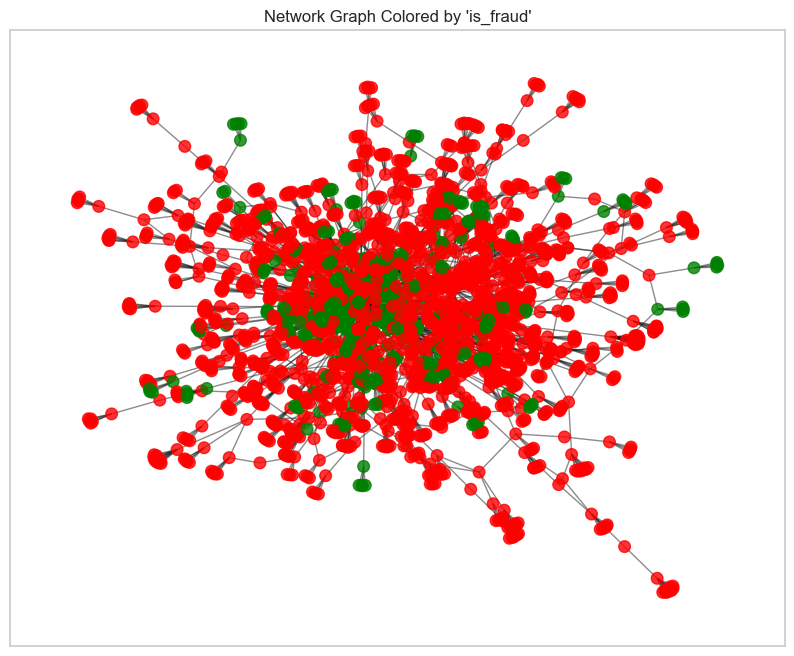

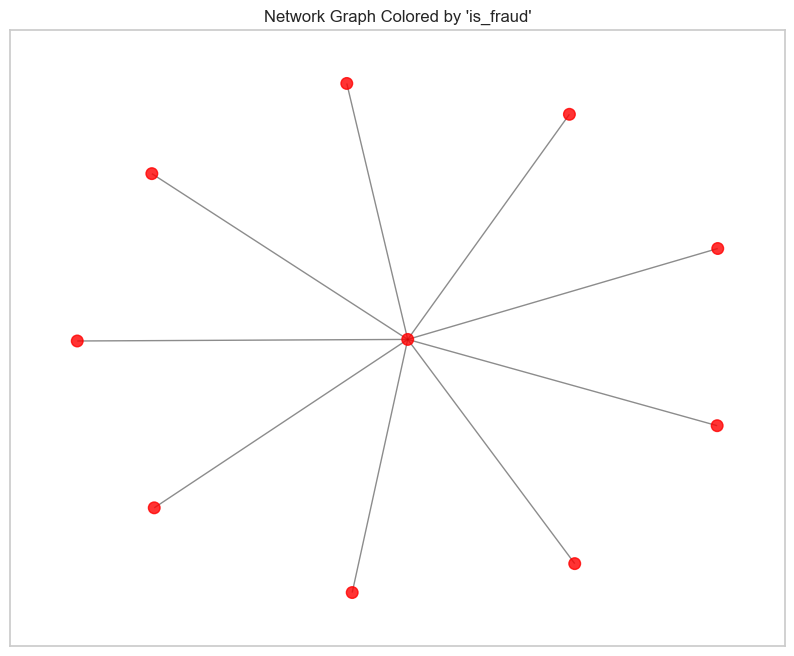

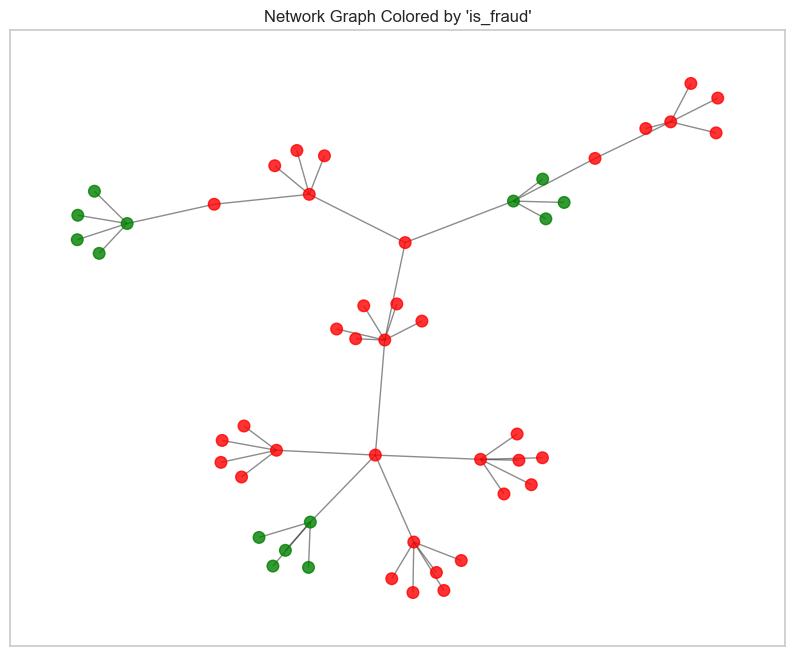

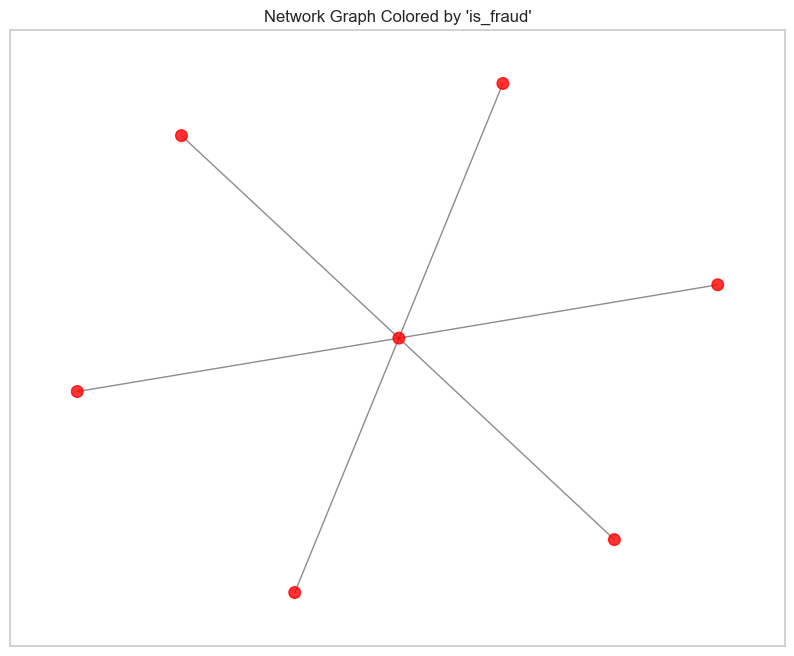

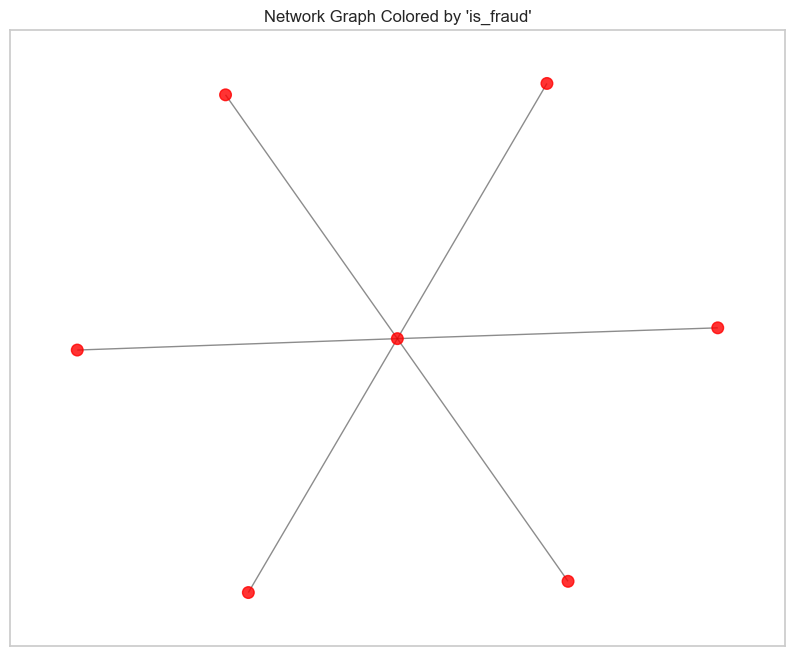

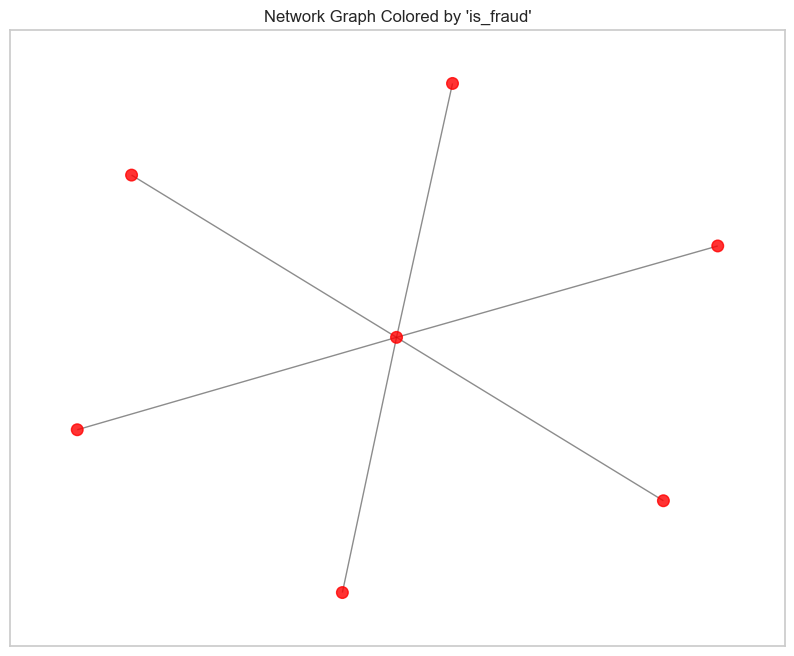

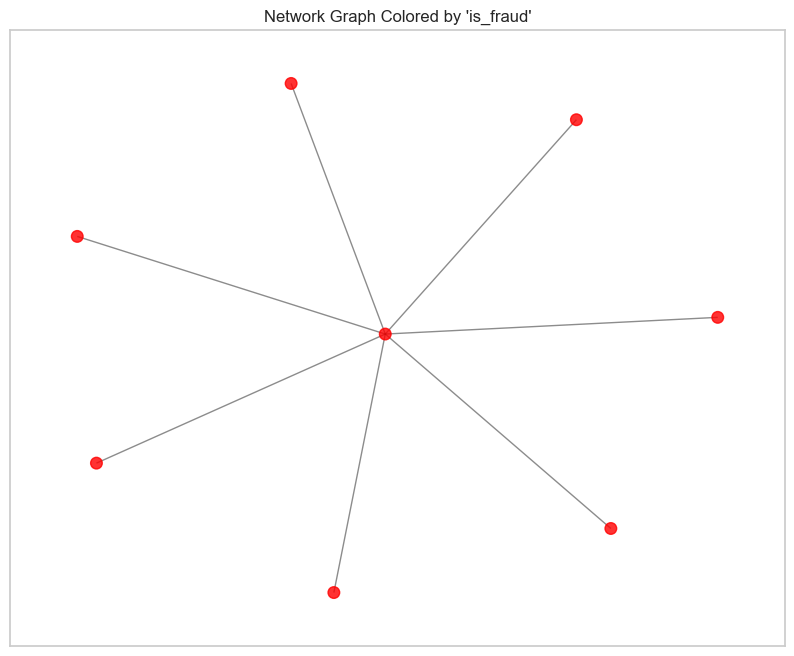

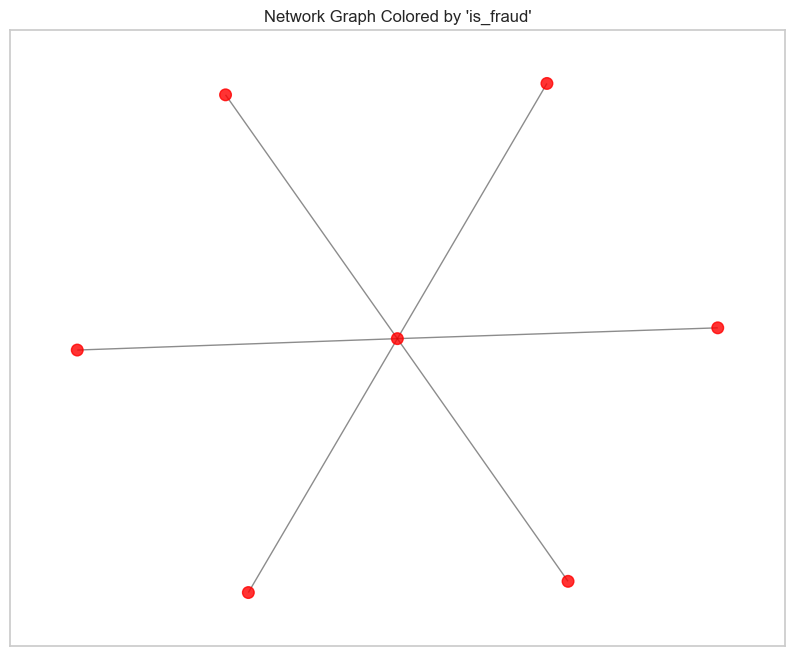

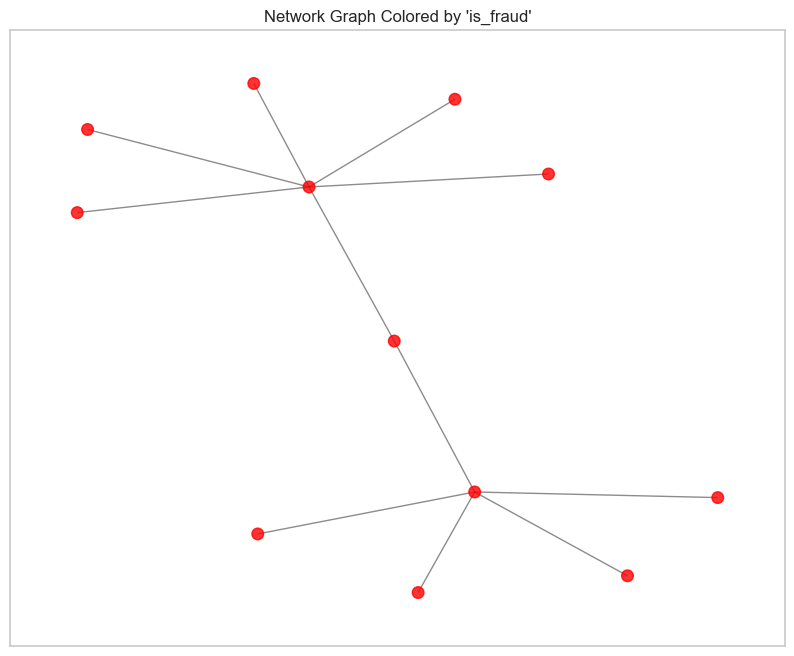

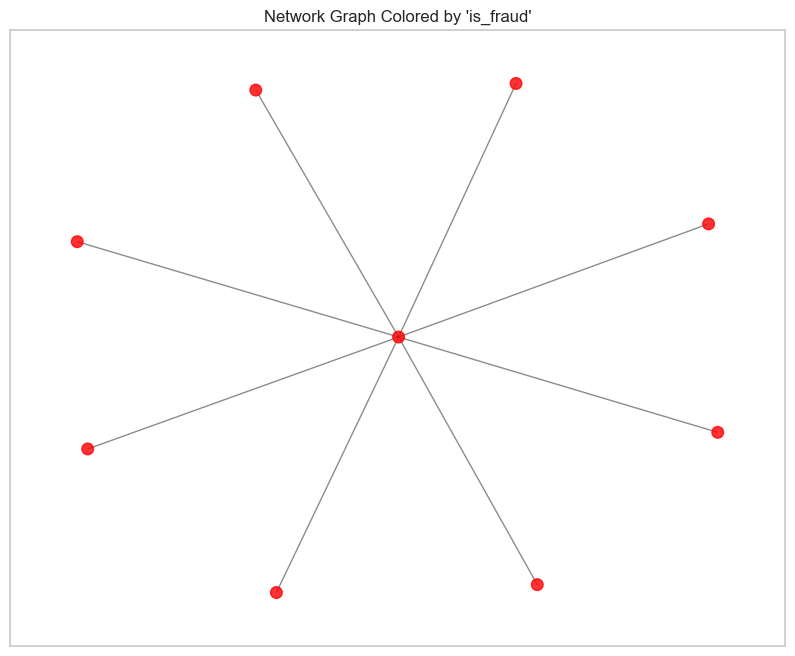

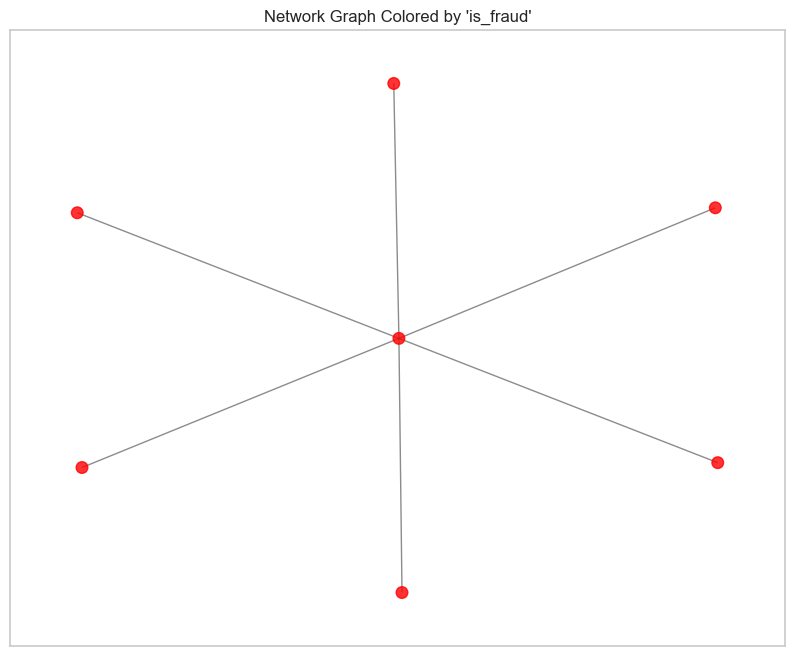

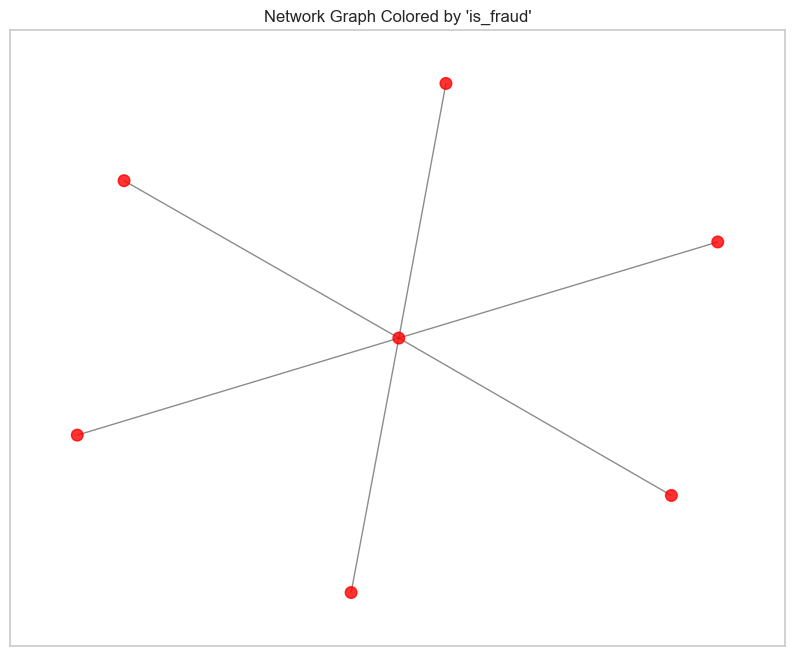

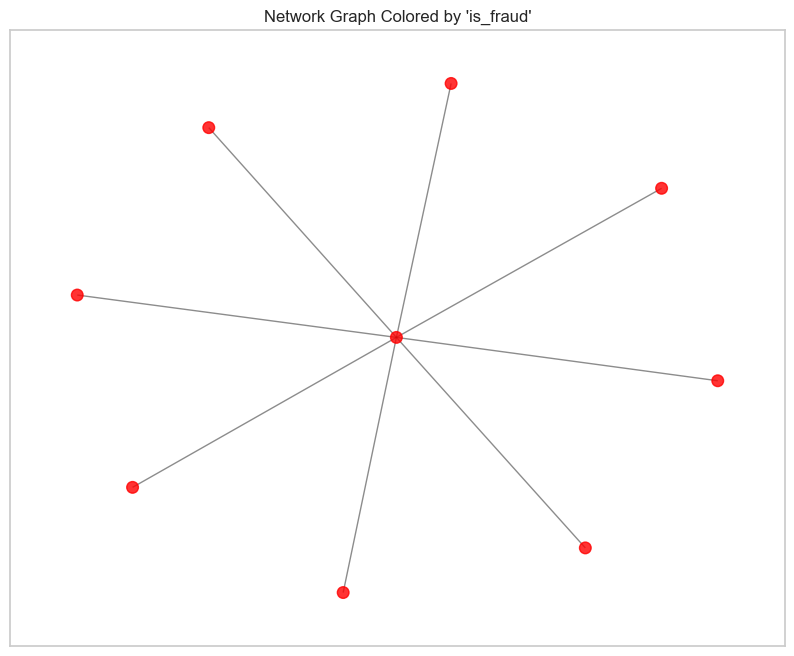

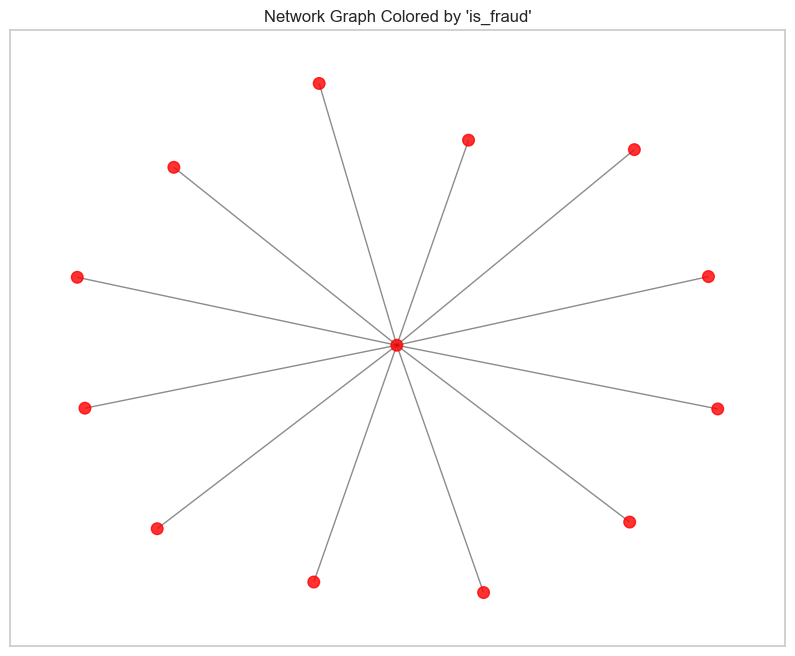

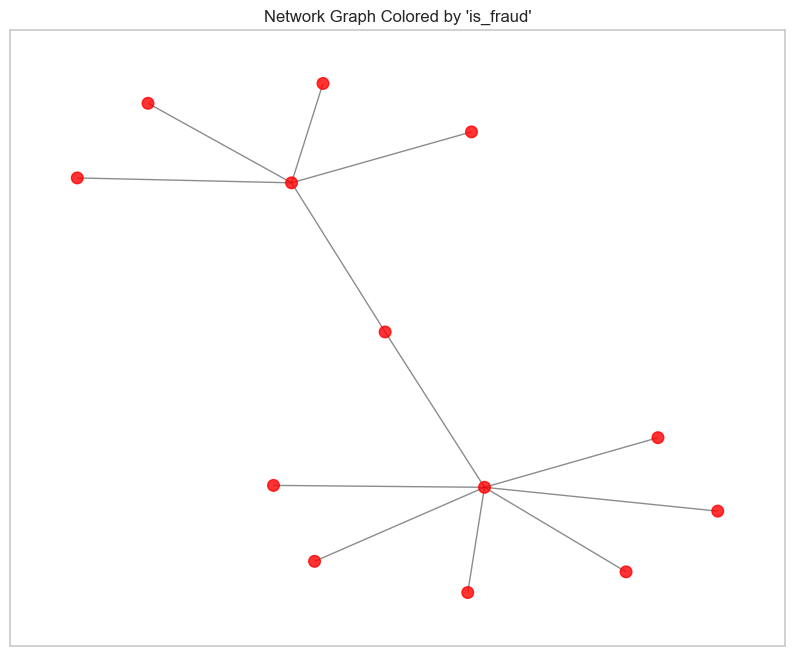

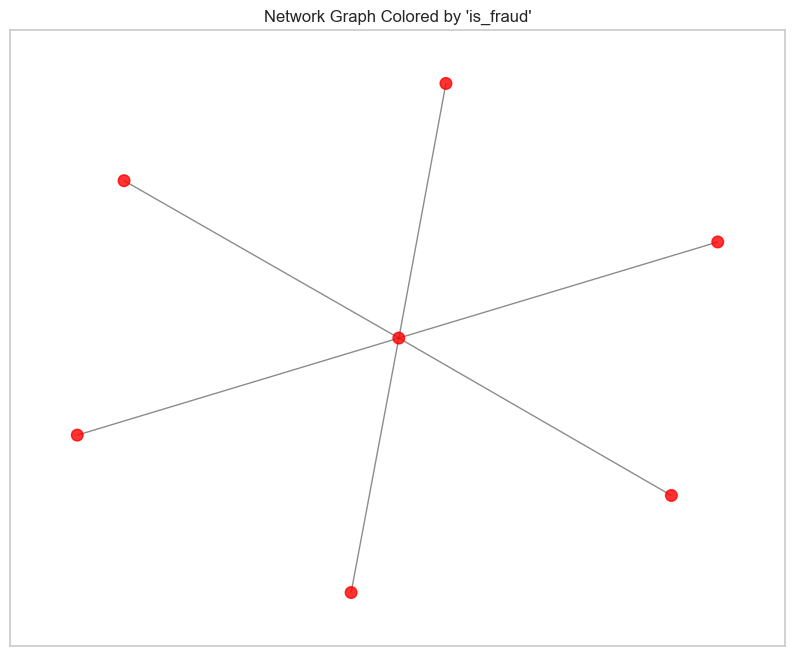

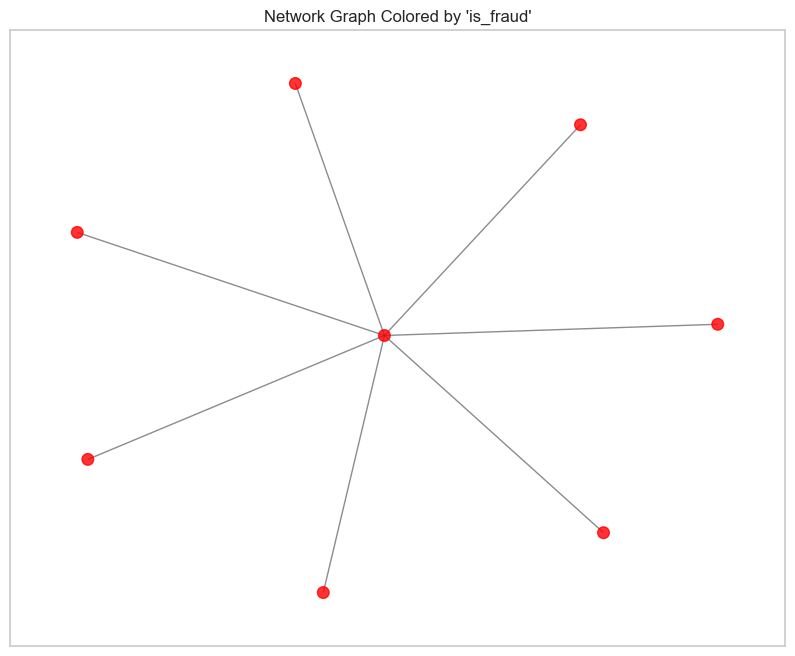

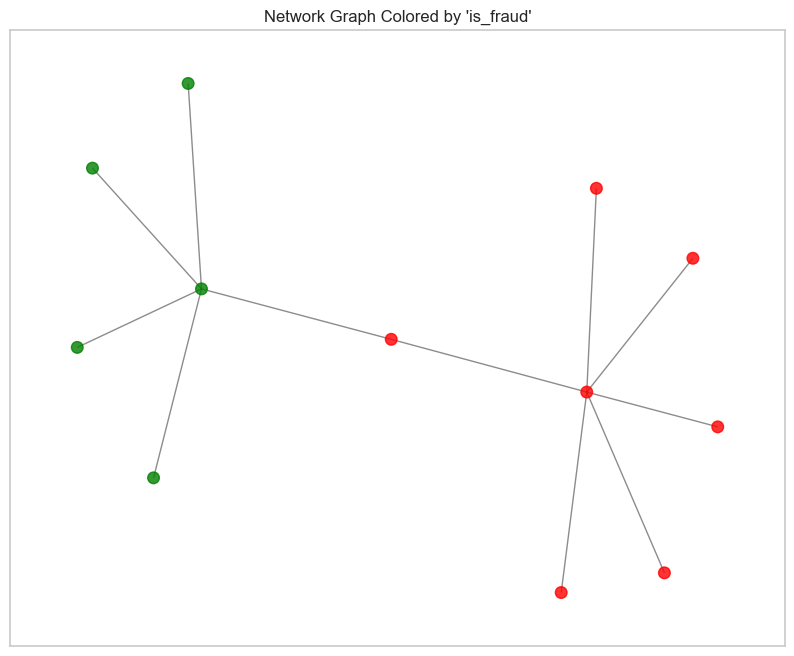

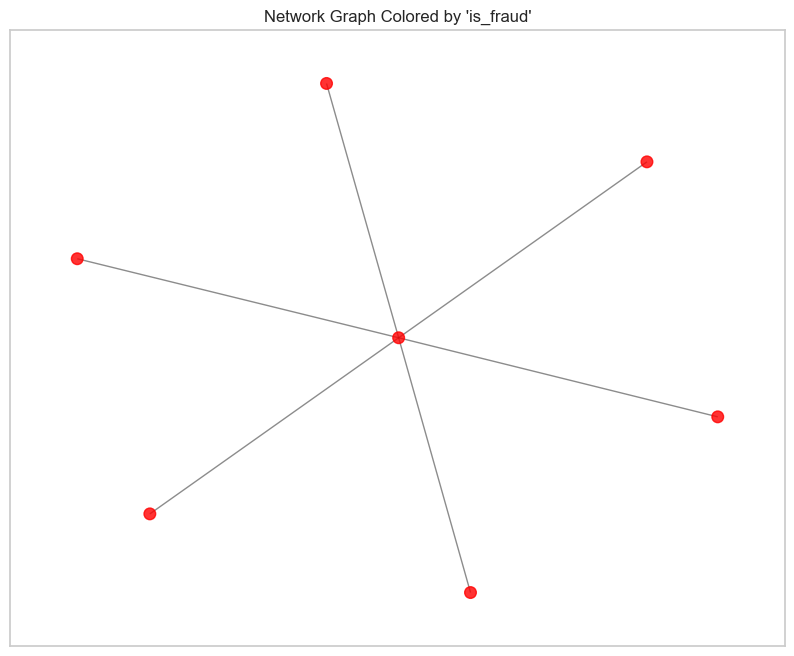

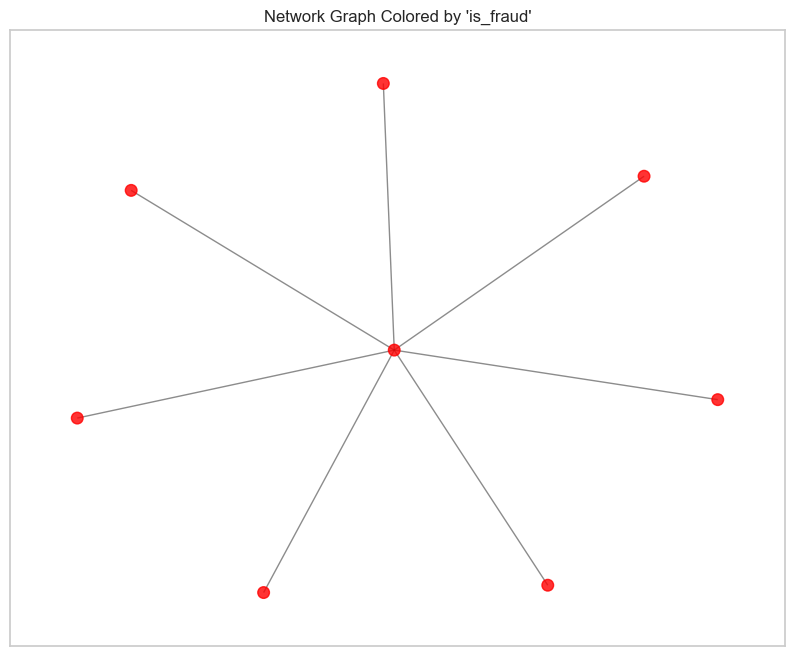

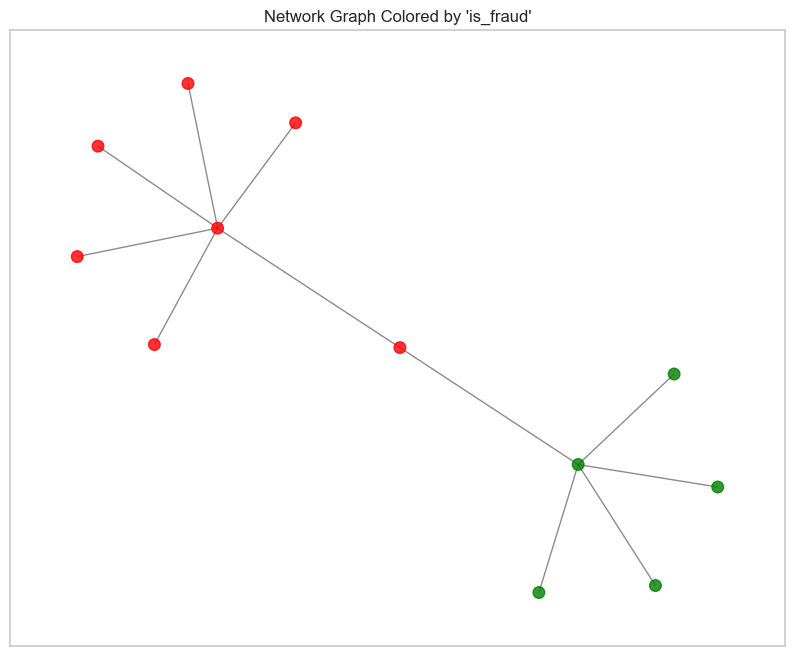

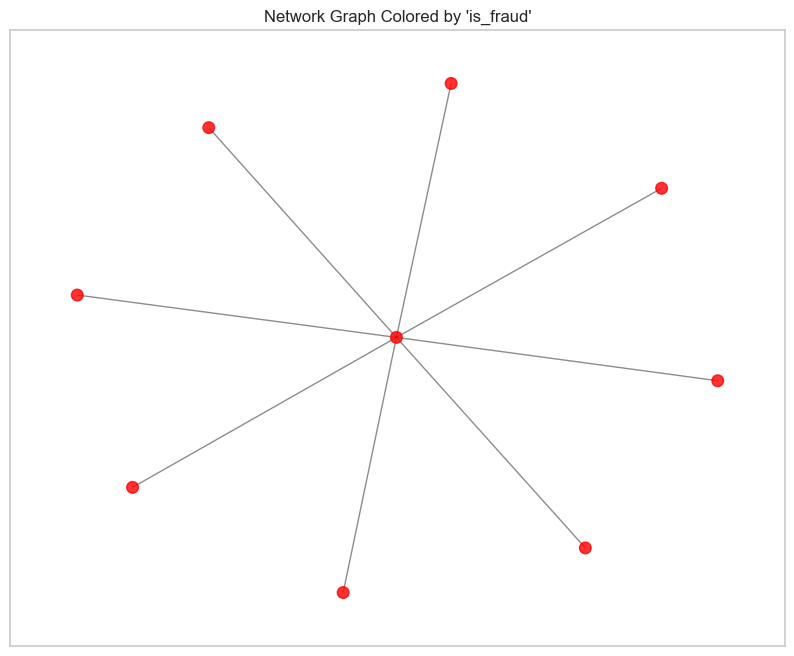

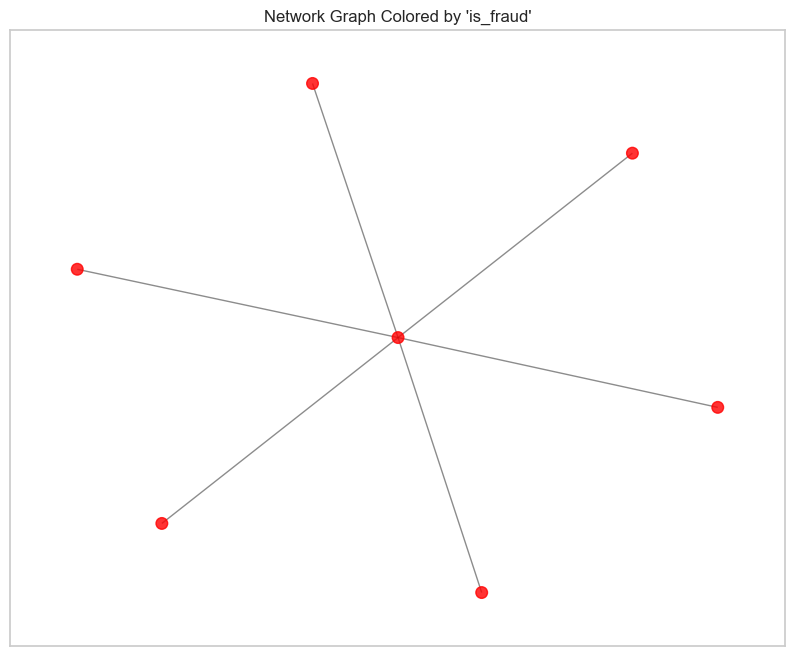

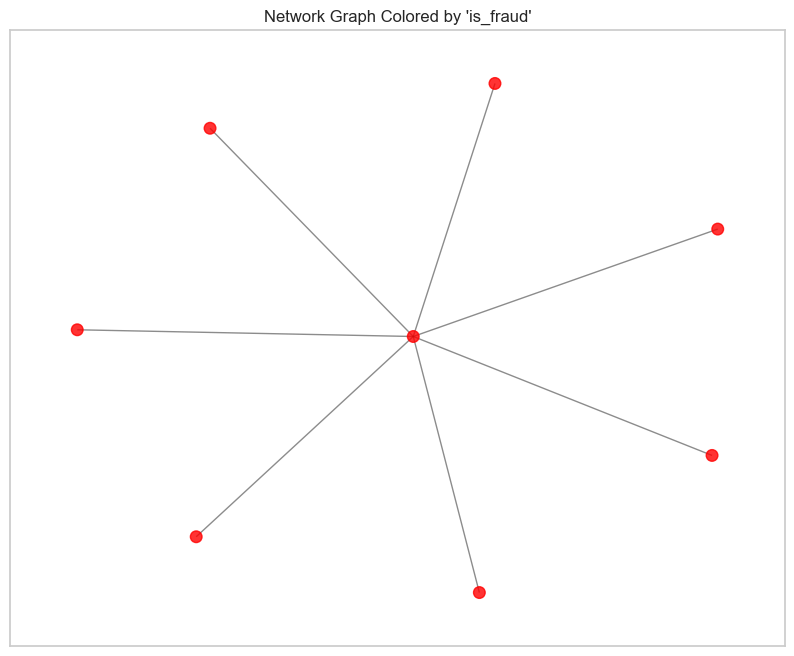

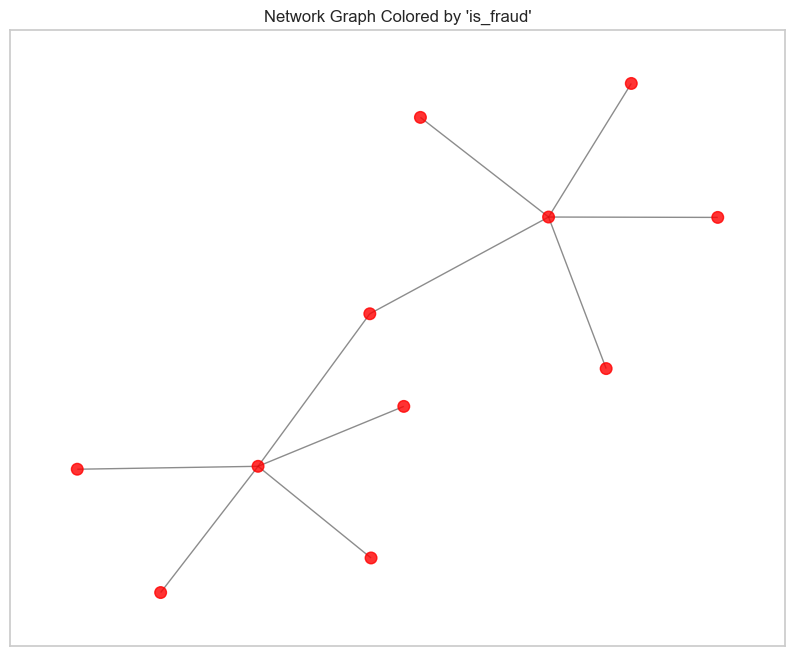

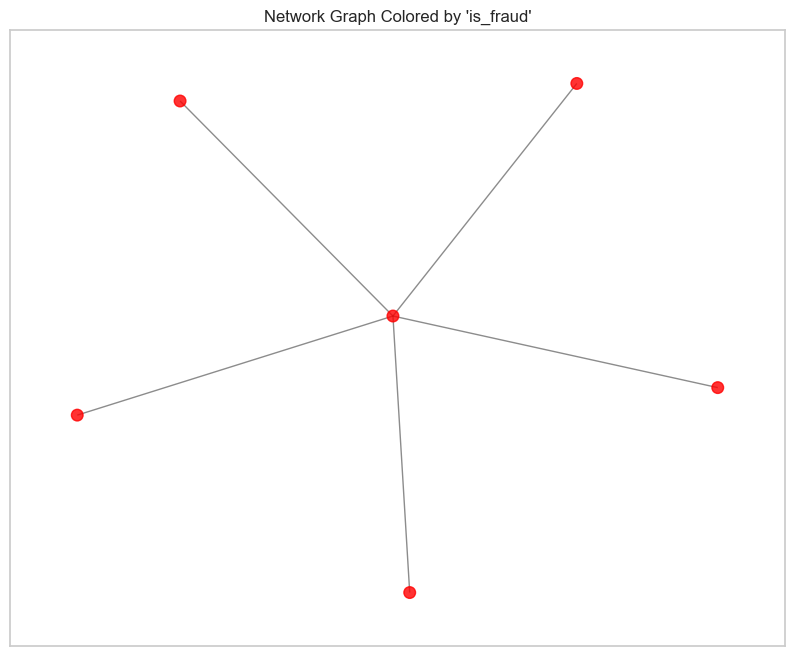

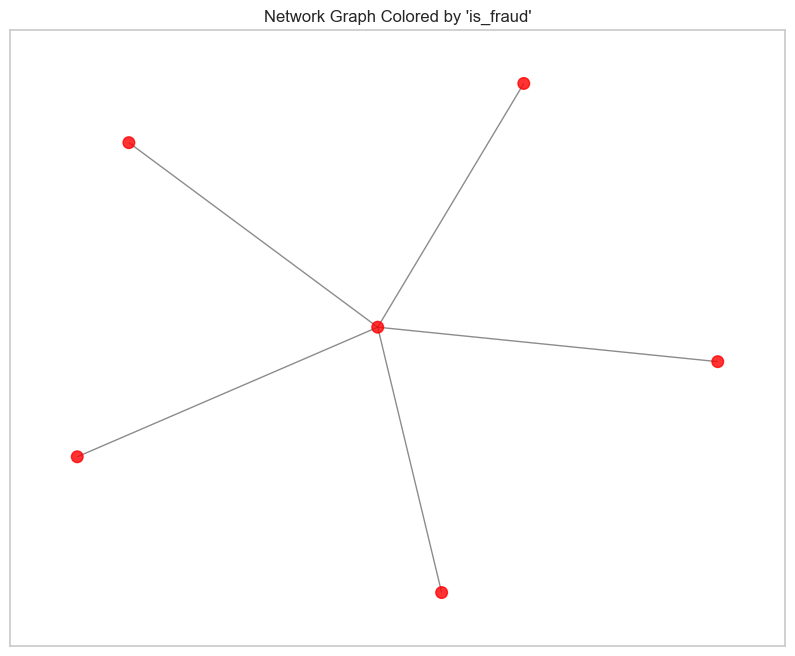

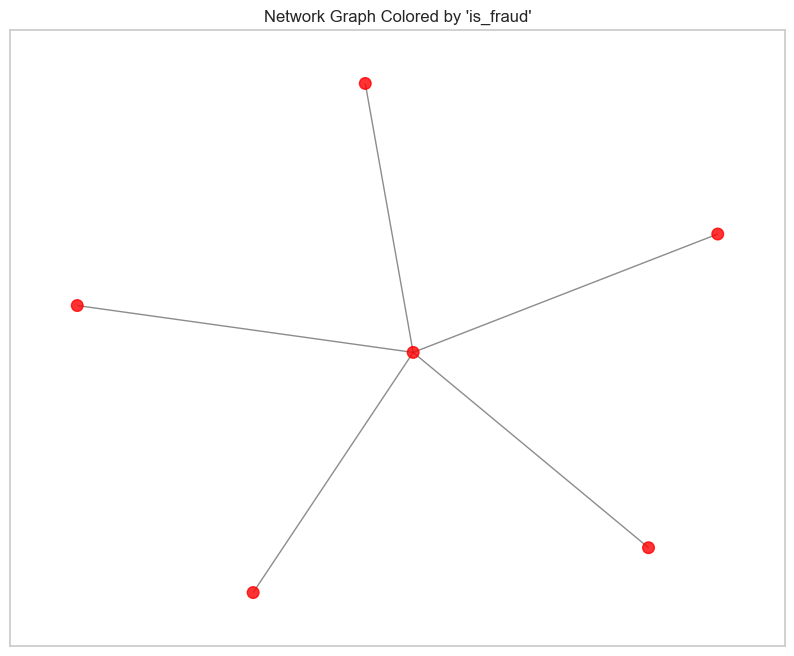

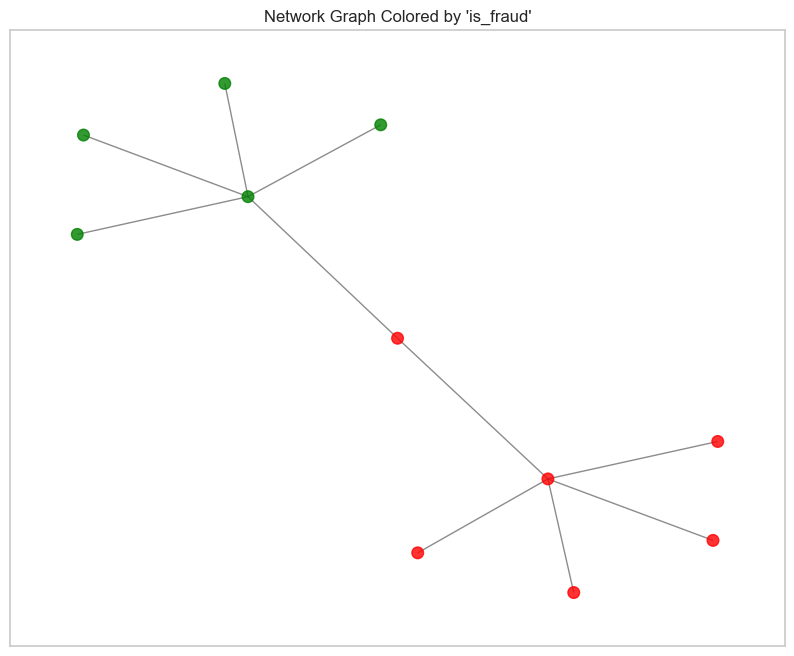

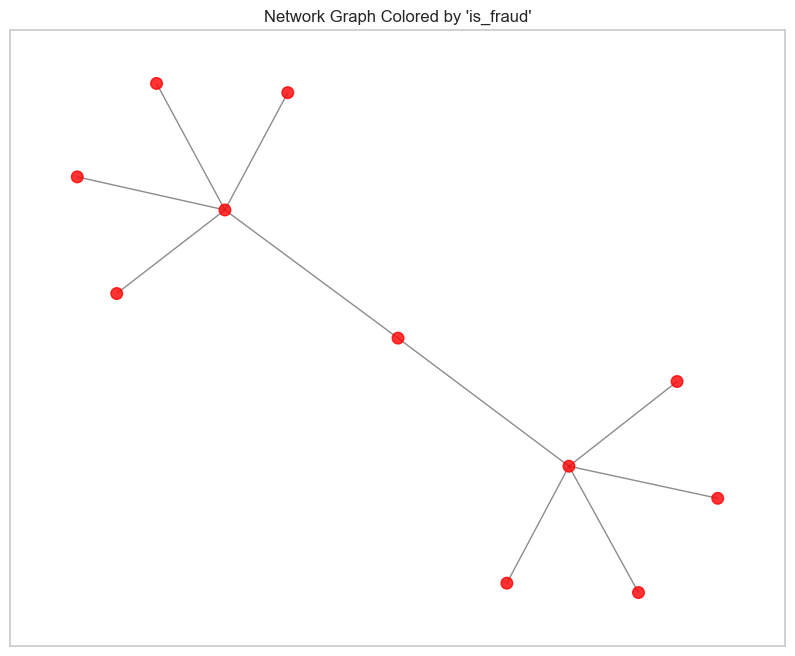

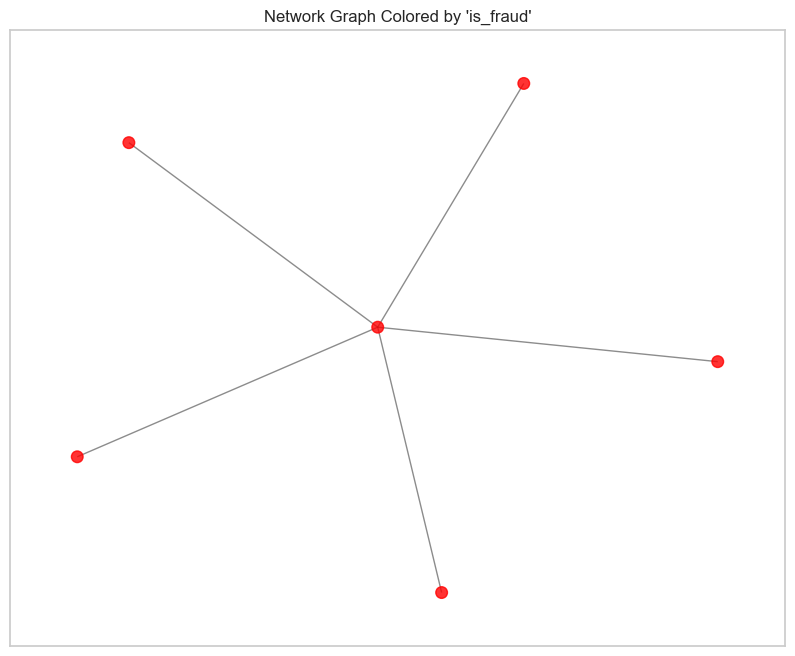

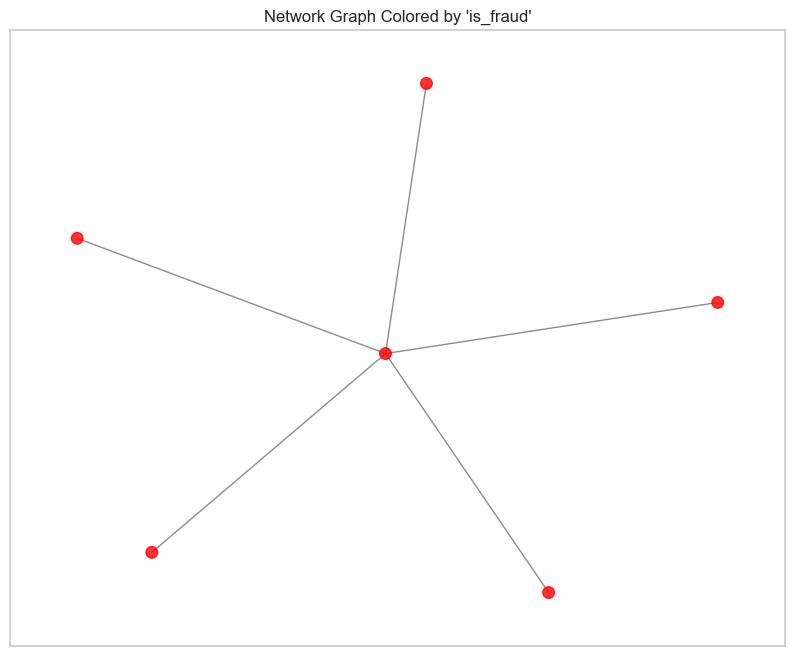

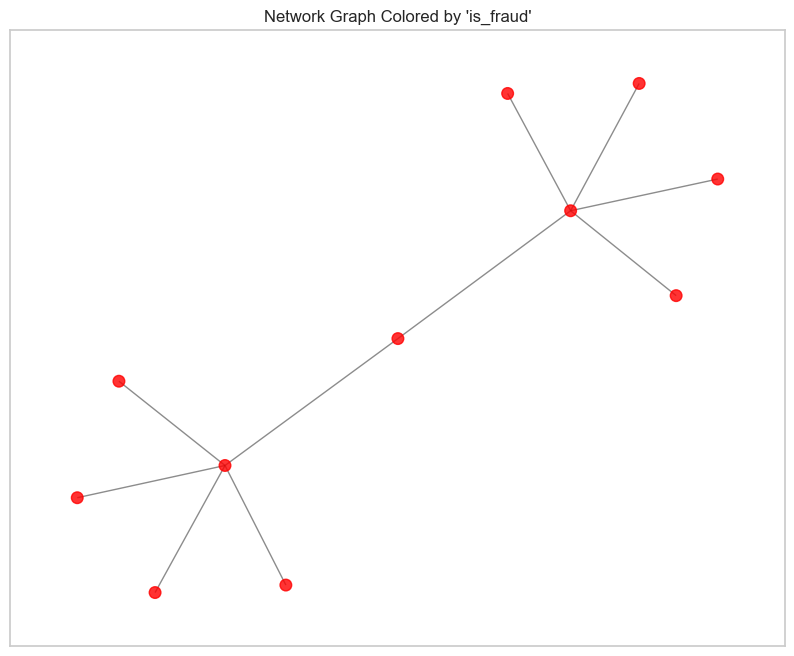

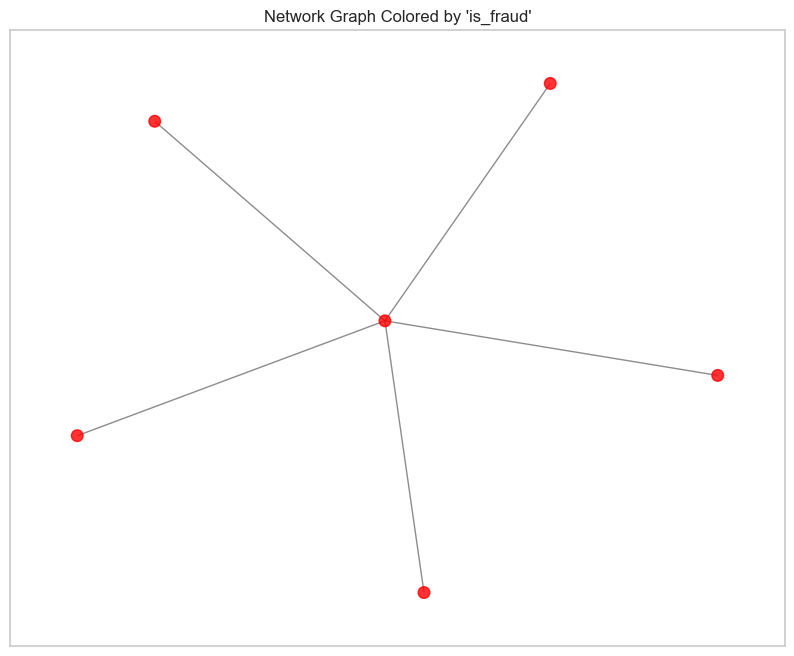

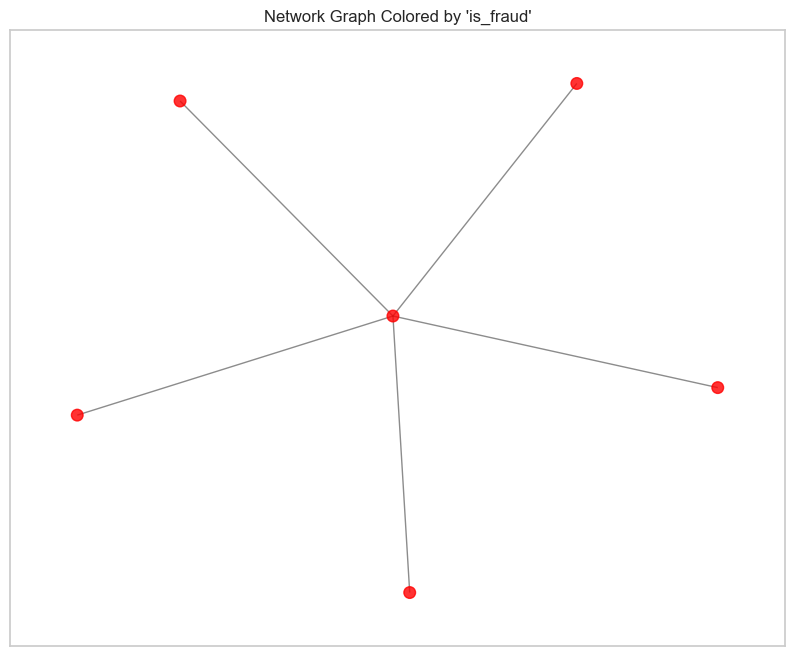

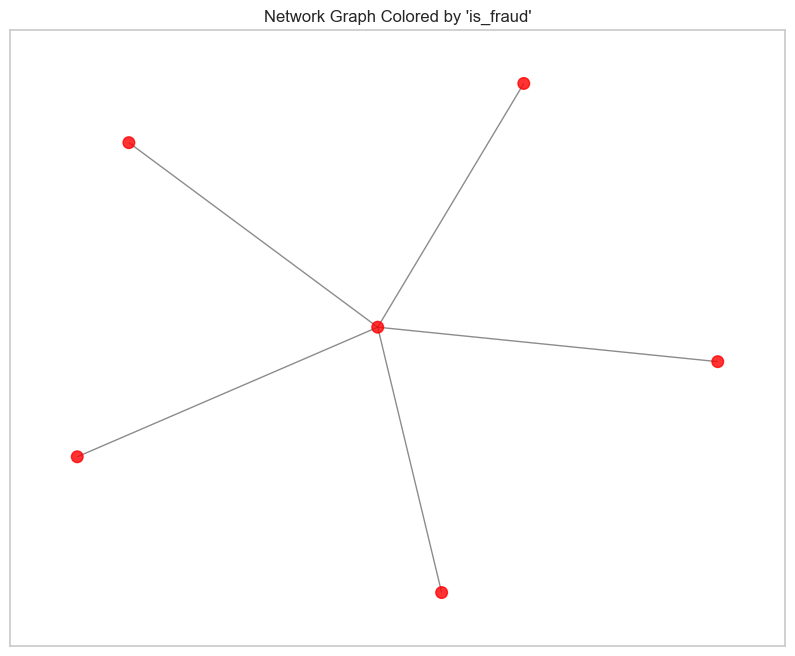

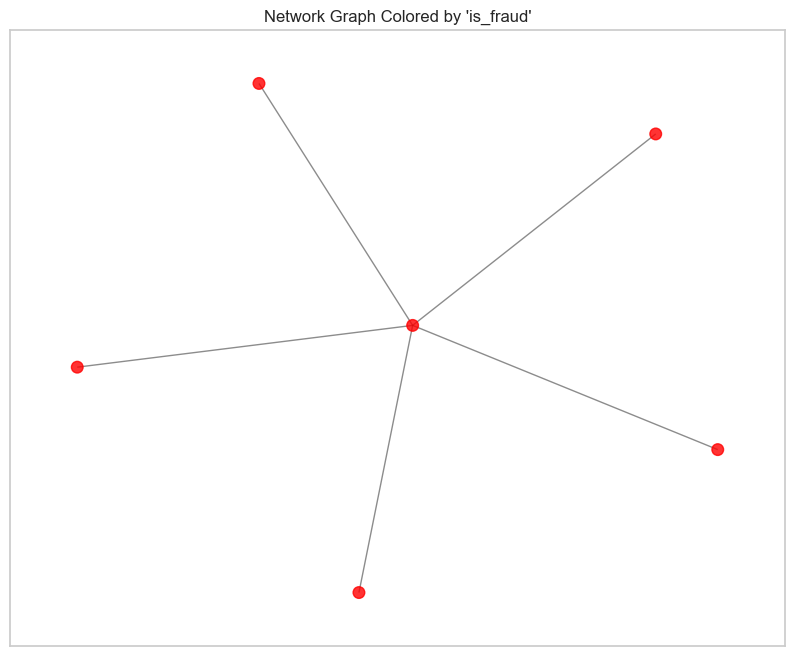

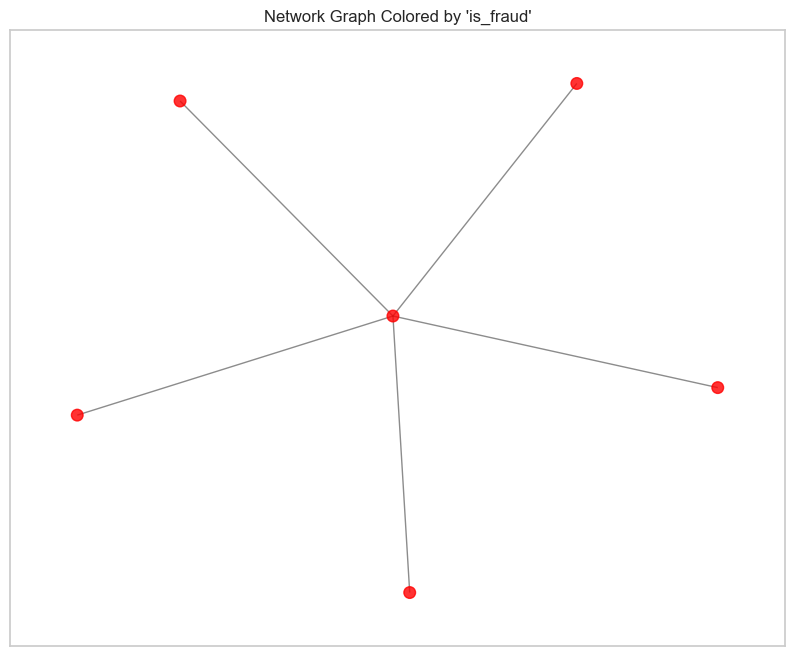

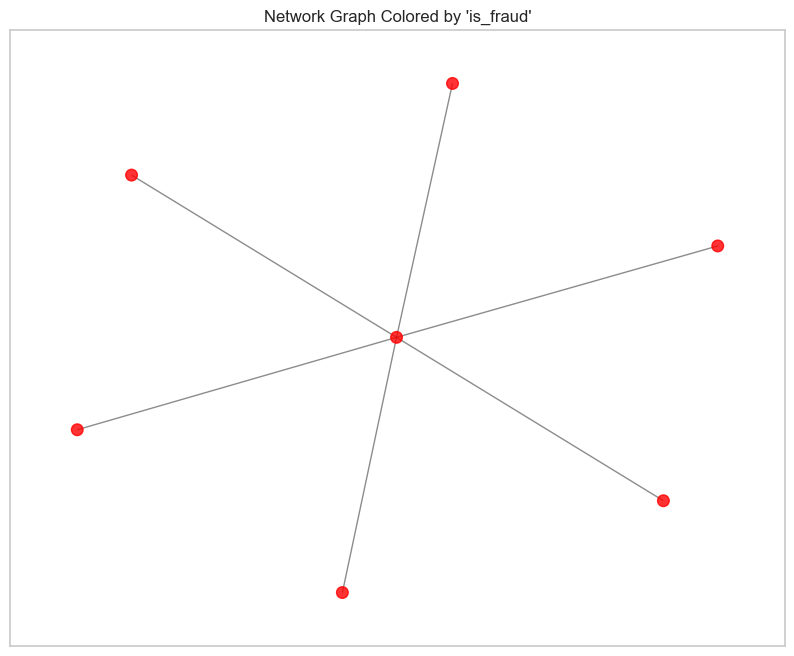

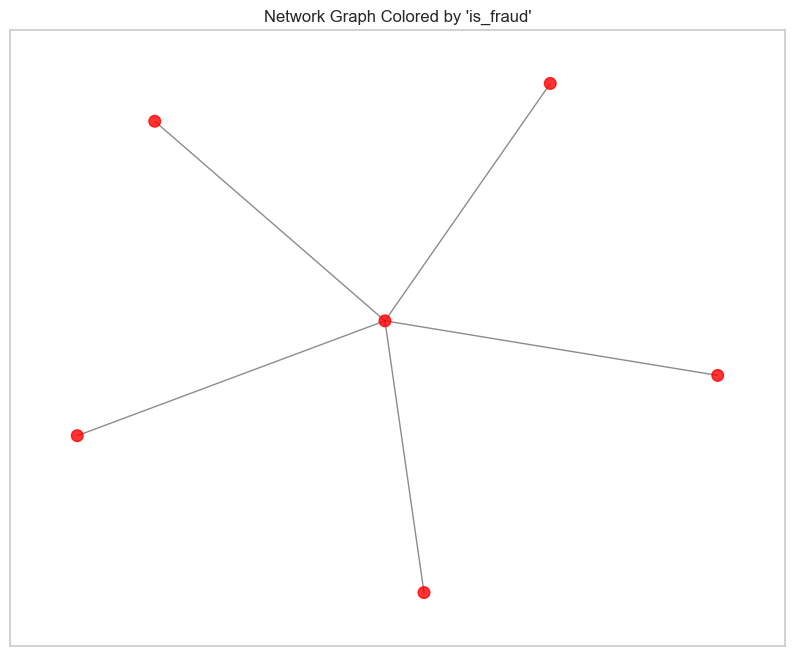

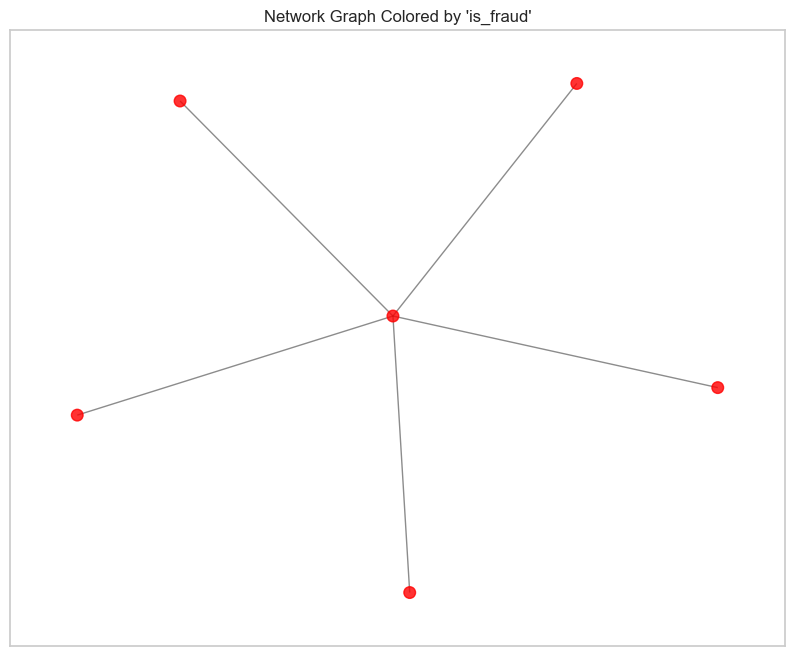

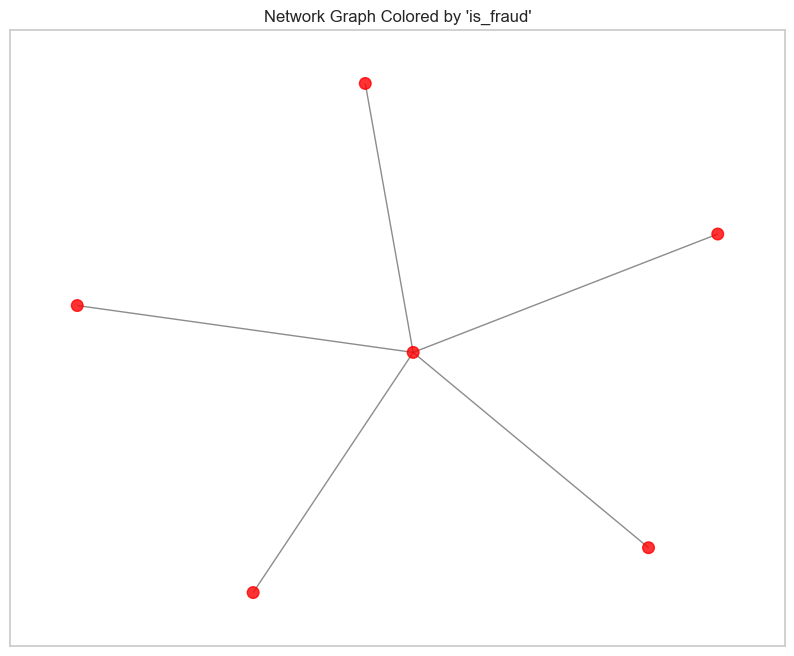

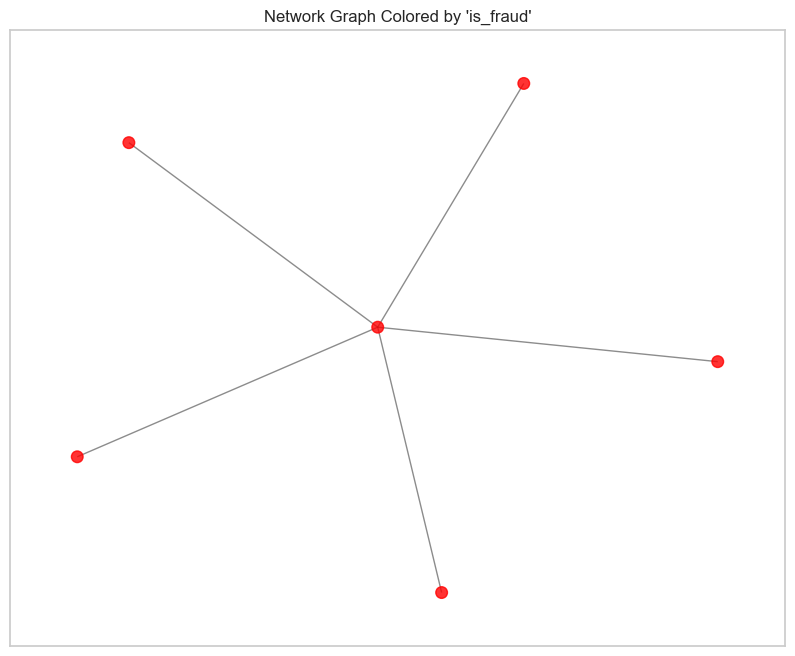

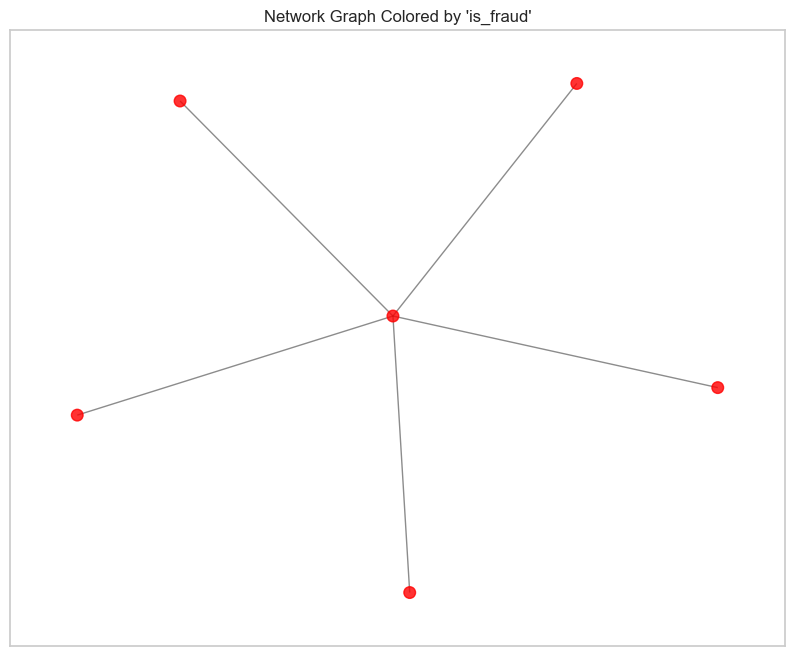

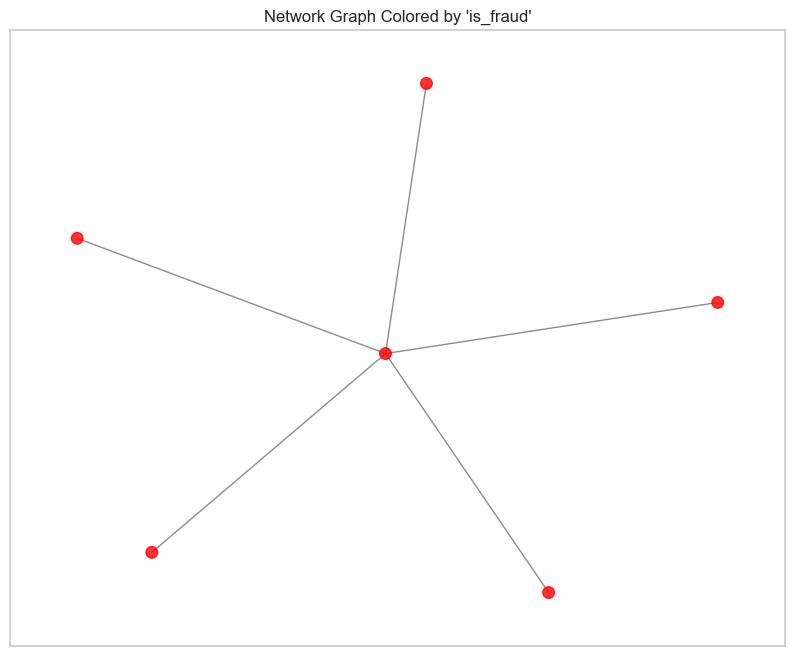

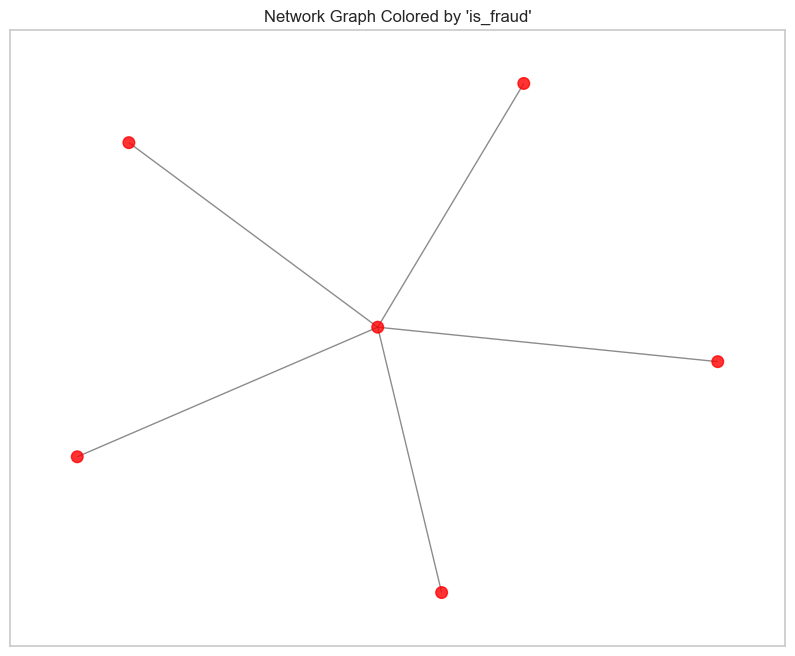

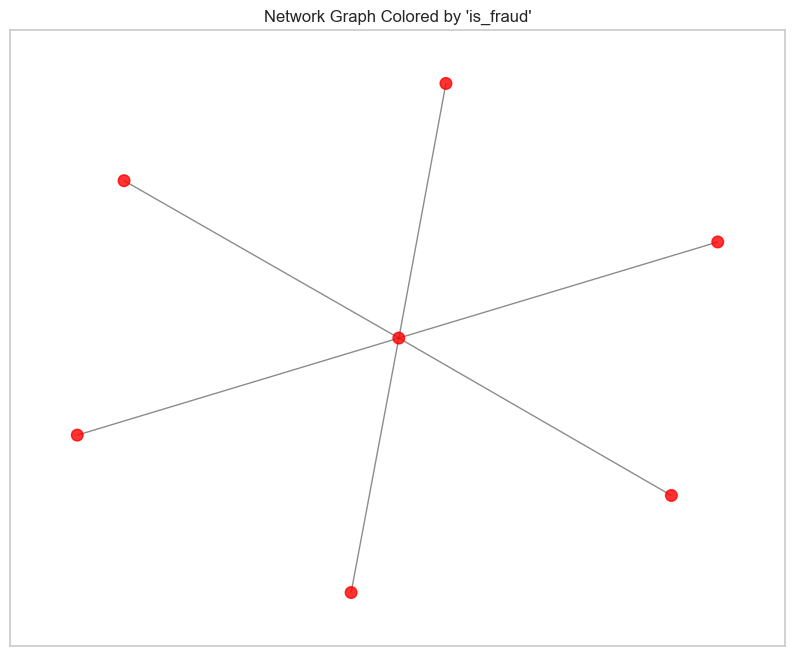

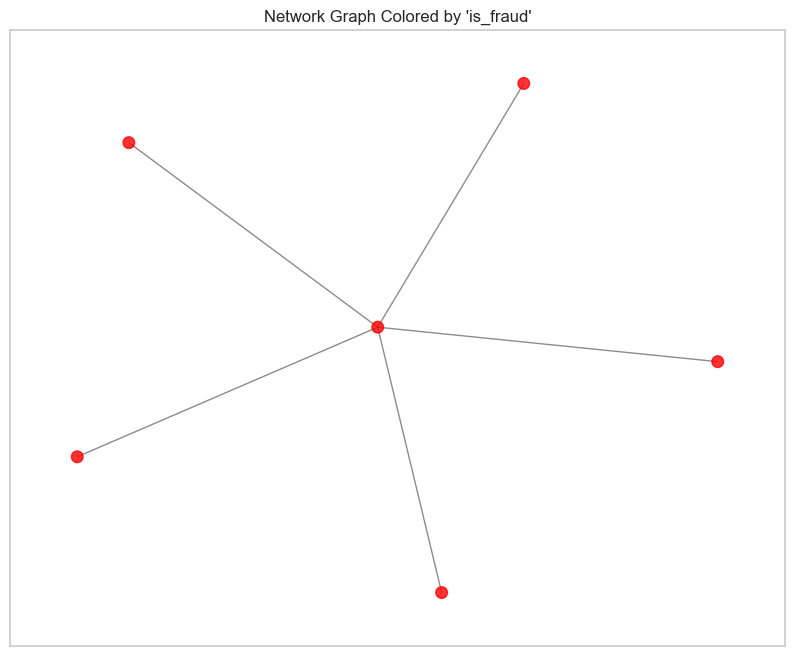

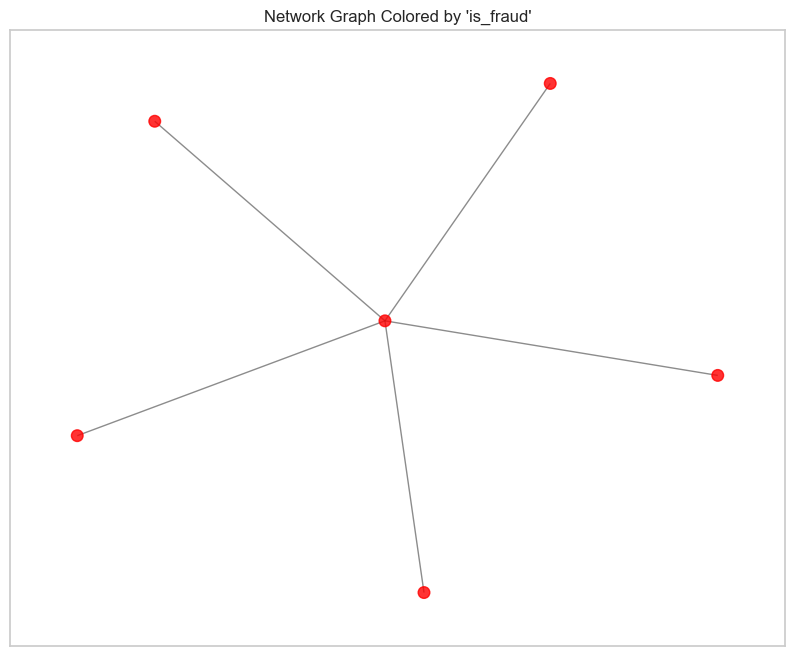

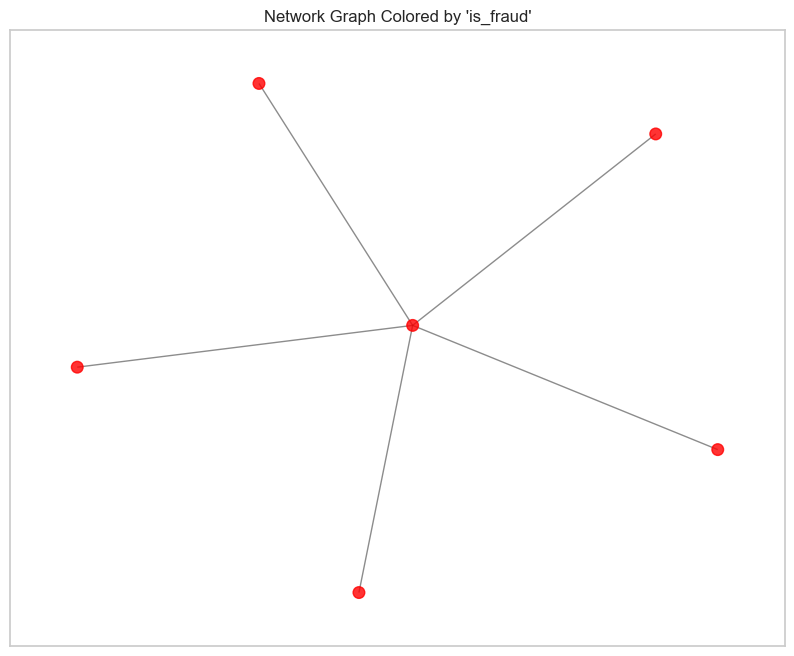

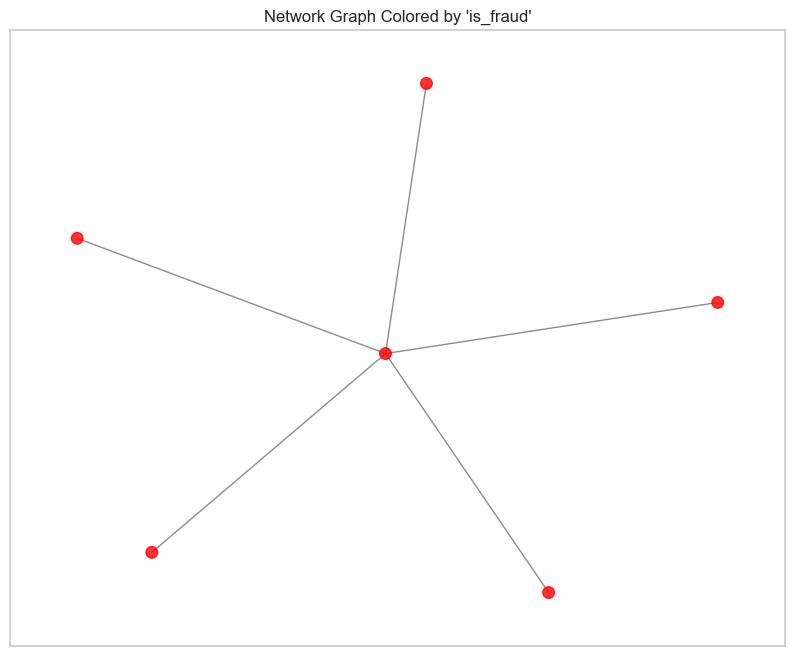

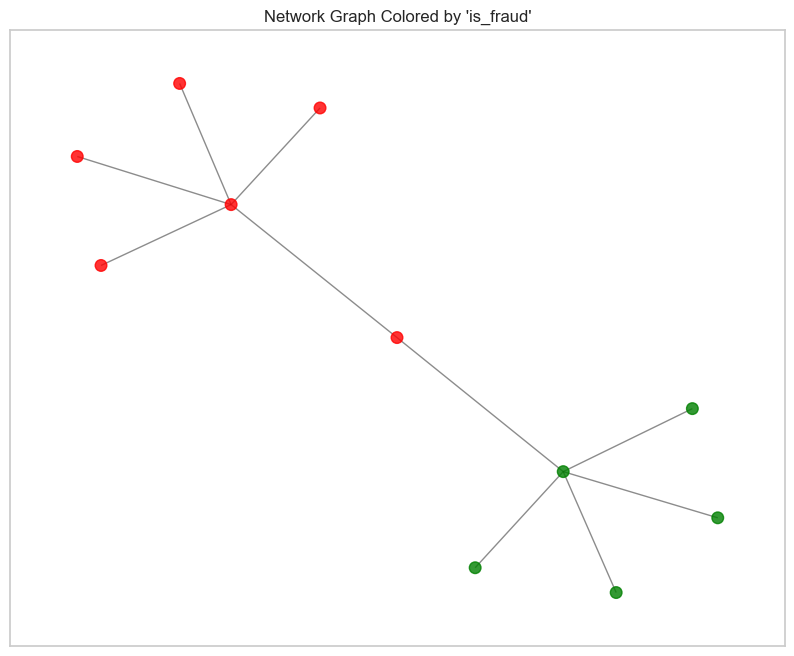

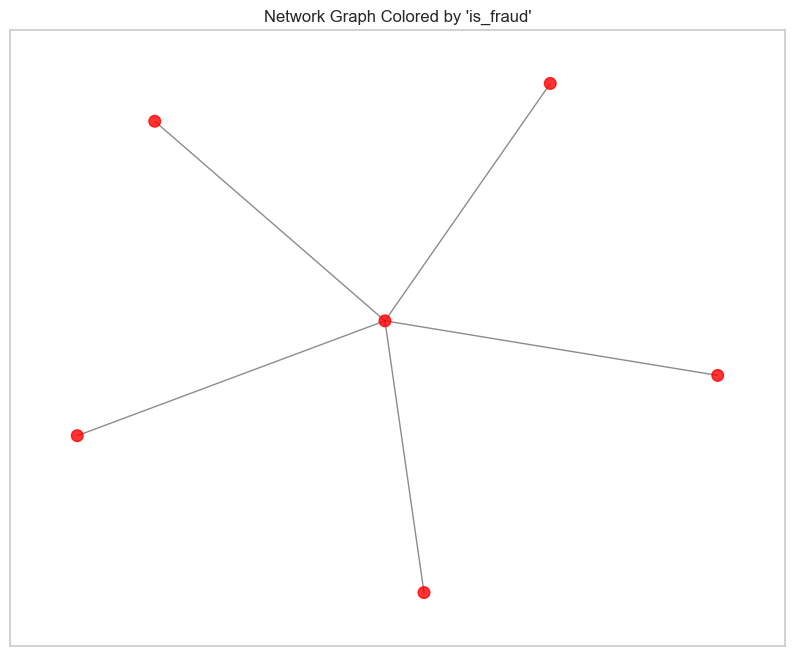

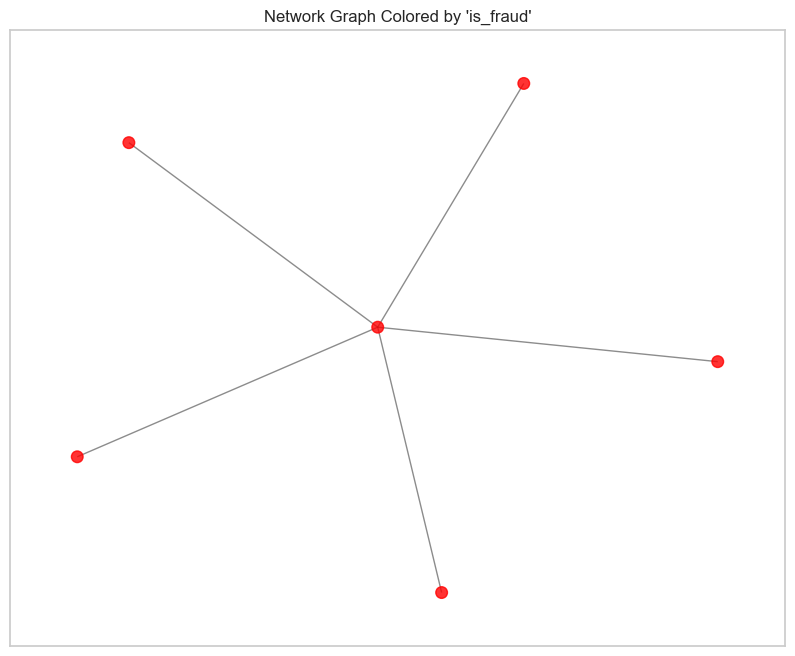

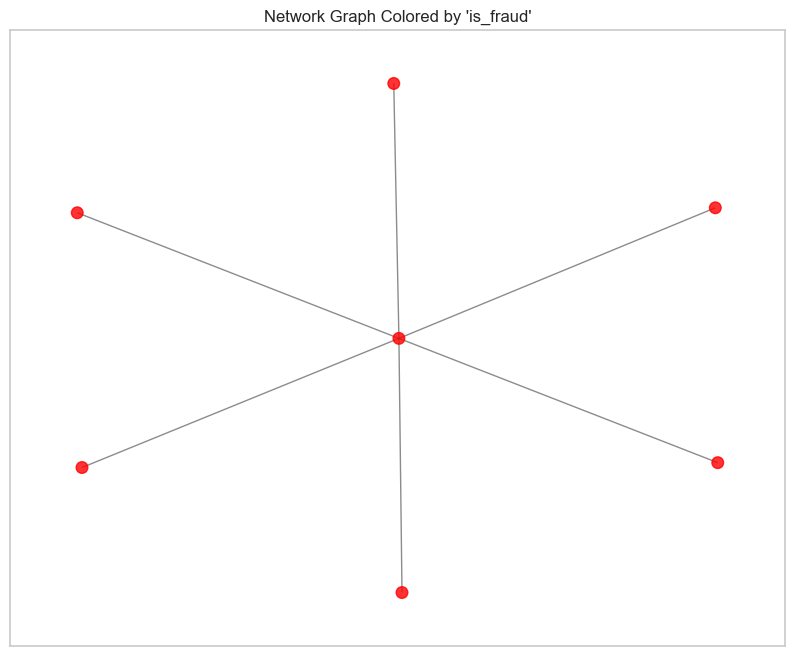

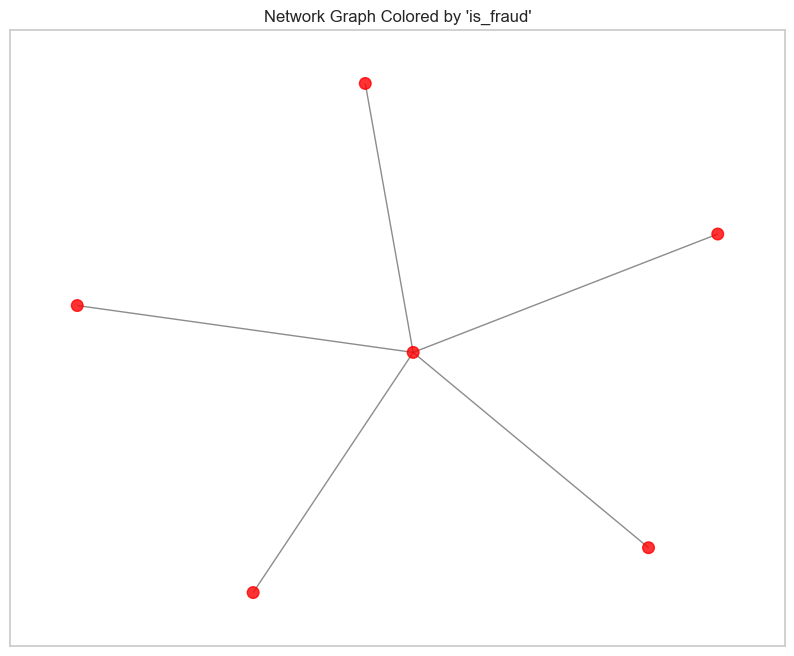

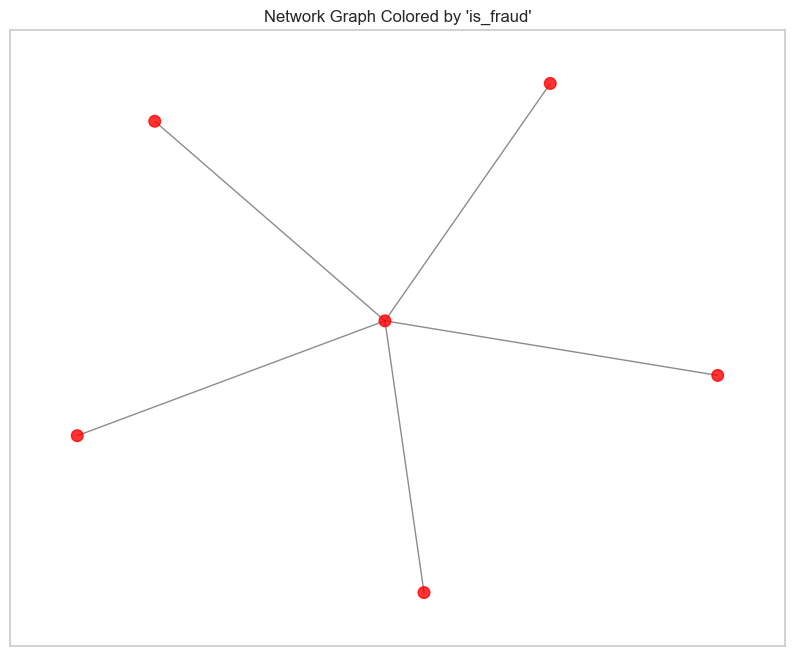

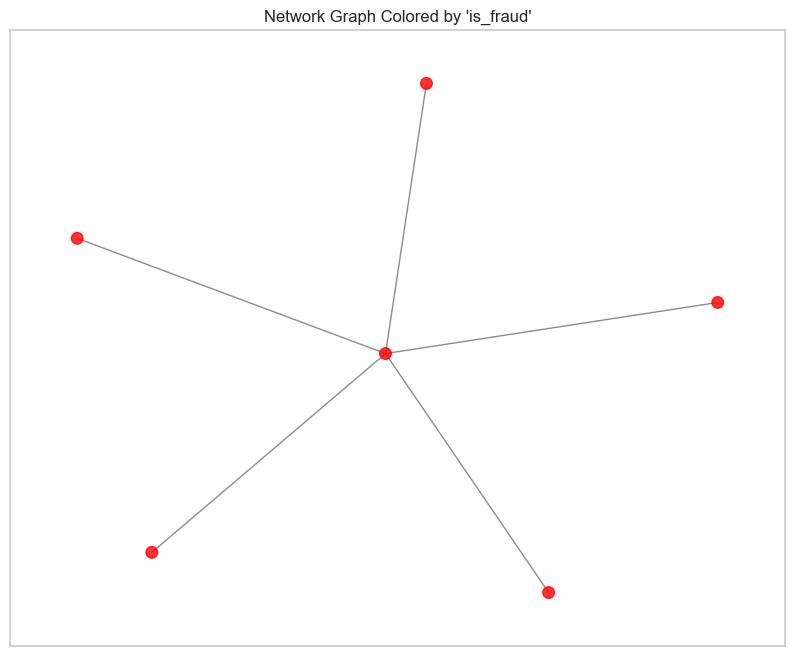

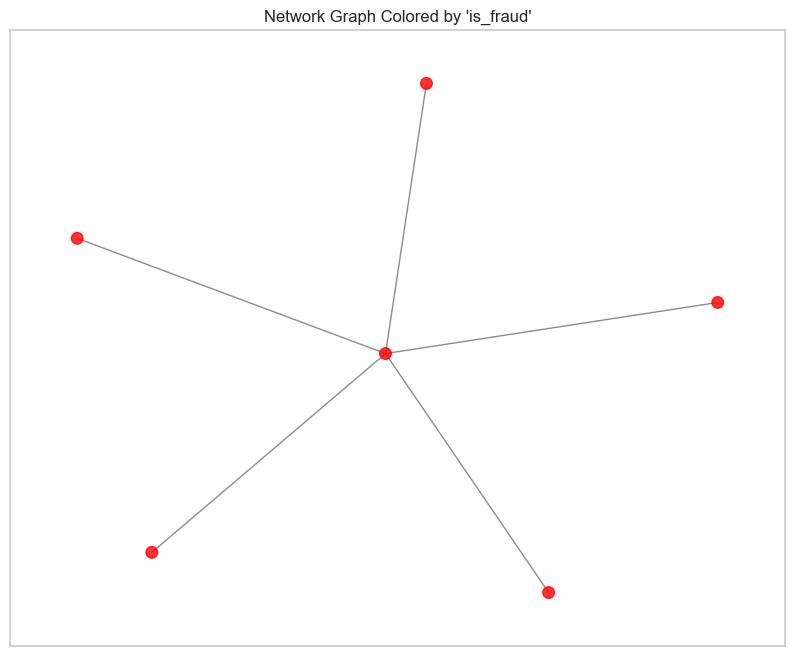

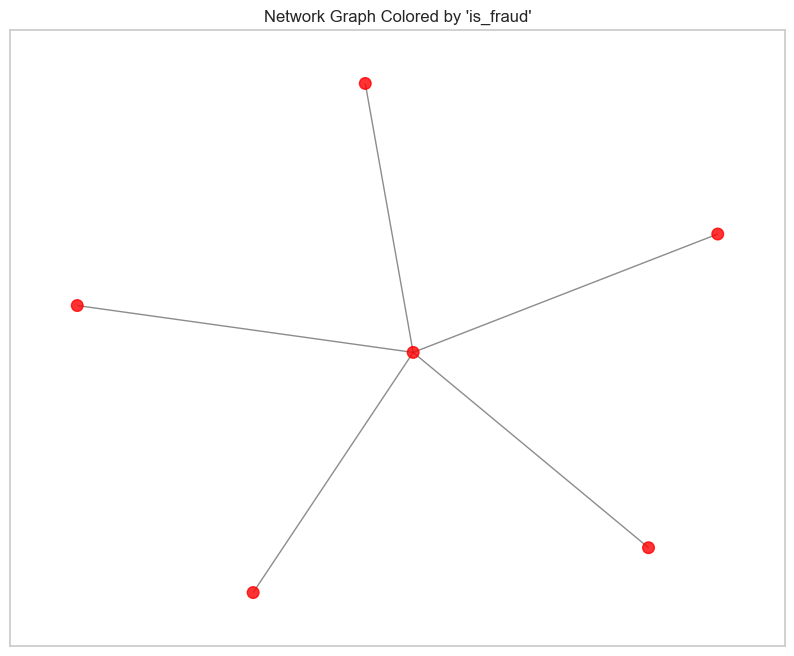

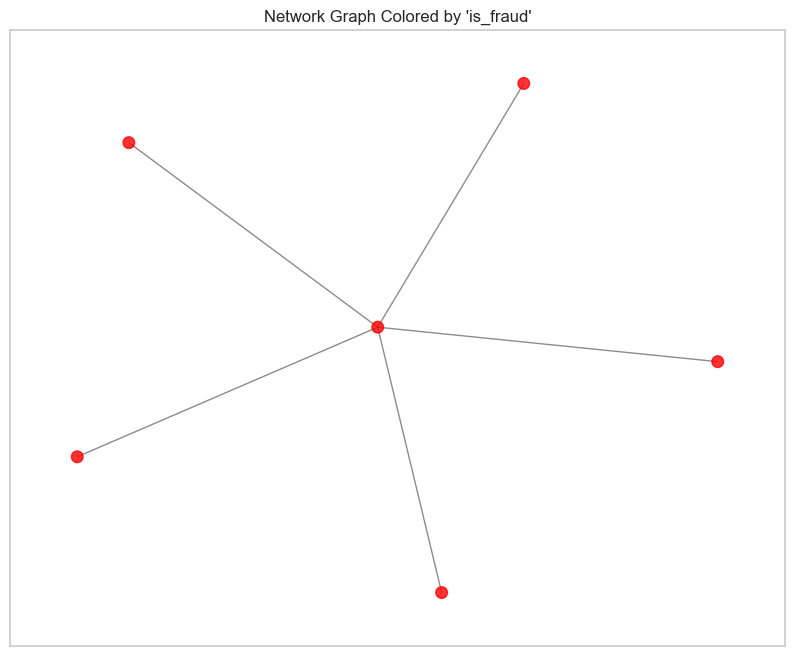

In [114]:
for subgraph in disjoint_subgraphs:
    plot_graph_colored_by_feature(subgraph)